In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

In [2]:
import pendulum
import ppo
importlib.reload(pendulum);
importlib.reload(ppo);

# Pendulum simulation with simple agent

In [3]:
env = pendulum.PendulumEnv(maxabs_tau=20)

In [19]:
T = 300
env.reset()
s = np.zeros((T, env.observation_dim))
r = np.zeros(T)
a = np.zeros(T)
time = np.zeros(T)
s[0,:] = env.s
for t in range(1,T):
    a[t] = 1.5 * s[t-1,0]
    s[t,:], r[t], _ = env.step(a[t])
    time[t] = (t - 1) * env.params['dt']

average reward per step = -0.5625513713848598


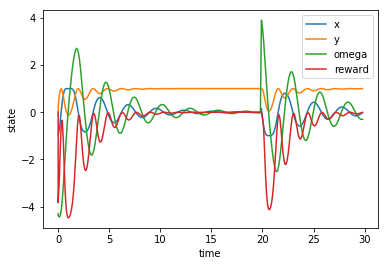

In [20]:
plt.plot(time, s[:,0], label='x')
plt.plot(time, s[:,1], label='y')
plt.plot(time, s[:,2], label='omega')
plt.plot(time, r, label='reward')
plt.xlabel('time')
plt.ylabel('state')
plt.legend()
print(f'average reward per step = {np.mean(r)}')

# Pendulum animation

In [21]:
def animate(s):
    fig, ax = plt.subplots()

    ax.set_xlim(( -1.2, 1.2))
    ax.set_ylim((-1.2, 1.2))
    ax.set_aspect('equal')

    line, = ax.plot([], [], lw=2)

    def init():
        line.set_data([], [])
        return (line,)

    def animate(i):
        x = [0, s[i,0]]
        y = [0, s[i,1]]
        line.set_data(x, y)
        return (line,)

    T = s.shape[0]
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=T, interval=20, 
                                   blit=True)
    return anim

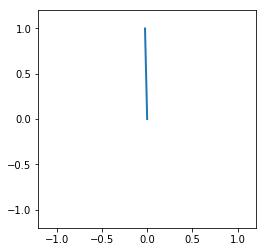

In [22]:
anim = animate(s)
HTML(anim.to_jshtml())

# PPO training

In [7]:
agent = ppo.PPOAgent(env)

In [8]:
gamma = 0.99
lamb = 0.95
number_of_actors = 50
number_of_iterations = 1000
horizon = 20
number_of_epochs = 100
minibatch_size = 100
logstd_initial = -1 #-0.7
logstd_final = -2 # -1.6
epsilon = 0.2
use_multiprocess = True
res = agent.train(
    'pend',
    gamma,
    lamb,
    number_of_actors,
    number_of_iterations,
    horizon,
    number_of_epochs,
    minibatch_size,
    logstd_initial,
    logstd_final,
    epsilon,
    use_multiprocess,
)

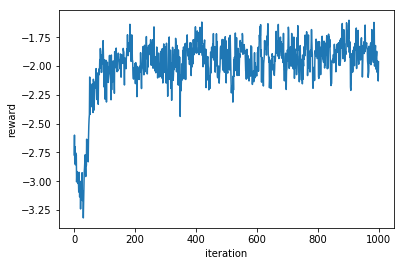

In [9]:
plt.plot(res['rewards'])
plt.xlabel('iteration')
plt.ylabel('reward');

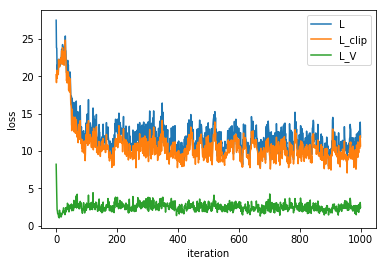

In [10]:
plt.plot(res['losses'], label='L')
plt.plot(res['losses_clip'], label='L_clip')
plt.plot(res['losses_V'], label='L_V')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

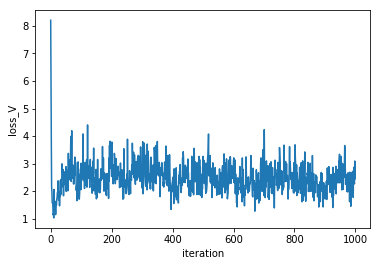

In [11]:
plt.plot(res['losses_V'], label='L_V')
plt.xlabel('iteration')
plt.ylabel('loss_V');

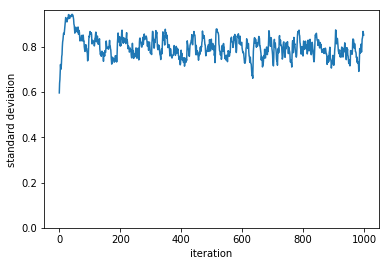

In [12]:
plt.plot(res['stds'])
plt.xlabel('iteration')
plt.gca().set_ylim(bottom=0)
plt.ylabel('standard deviation');

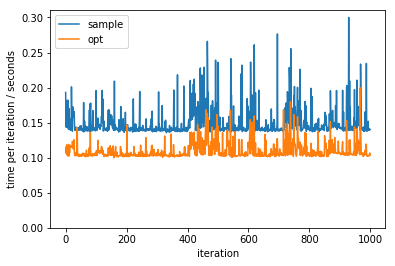

In [13]:
plt.plot(res['times_sample'], label='sample')
plt.plot(res['times_opt'], label='opt')
plt.gca().set_ylim(bottom=0)
plt.legend();
plt.xlabel('iteration')
plt.ylabel('time per iteration / seconds');

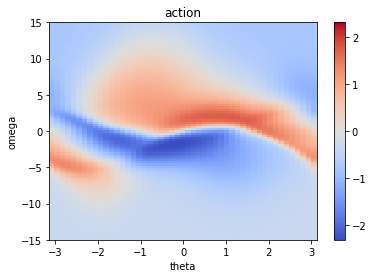

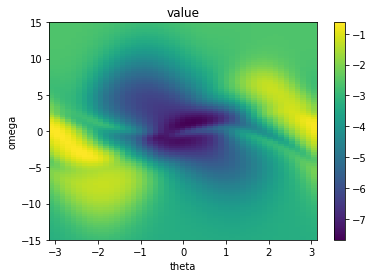

In [14]:
ni = 50
nj = 100
theta = np.linspace(-env.params['maxabs_theta'], env.params['maxabs_theta'], ni)
omega = np.linspace(-env.params['maxabs_omega'], env.params['maxabs_omega'], nj)
a = np.empty((nj, ni))
V = np.empty((nj, ni))
for i in range(ni):
    for j in range(nj):
        z = np.array([theta[i], omega[j]])
        s = env.z2s(z)
        a[j, i] = agent.action_greedy(s)
        V[j, i] = agent.value(s)

a_lim = np.max(np.abs(a))
c = plt.pcolor(theta, omega, a, cmap='coolwarm', vmin=-a_lim, vmax=a_lim)
plt.title('action')
plt.xlabel('theta')
plt.ylabel('omega')
plt.colorbar(c);

plt.figure()
c = plt.pcolor(theta, omega, V)
plt.title('value')
plt.xlabel('theta')
plt.ylabel('omega')
plt.colorbar(c);

# Pendulum simulation with agent

In [23]:
T = 200
env.reset()
s = np.zeros((T, env.observation_dim))
r = np.zeros(T)
a = np.zeros(T)
time = np.zeros(T)
s[0,:] = env.s
for t in range(1,T):
    a[t] = agent.action_greedy(s[t-1,:])
    s[t,:], r[t], _ = env.step(a[t])
    time[t] = (t - 1) * env.params['dt']

average reward per step = -0.16211333042847095


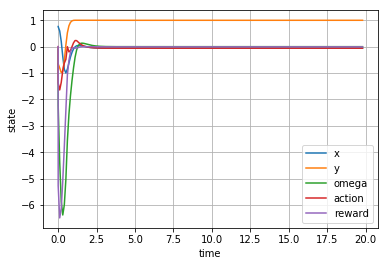

In [24]:
plt.plot(time, s[:,0], label='x')
plt.plot(time, s[:,1], label='y')
plt.plot(time, s[:,2], label='omega')
plt.plot(time, a, label='action')
plt.plot(time, r, label='reward')
plt.xlabel('time')
plt.ylabel('state')
plt.legend()
plt.grid()
print(f'average reward per step = {np.mean(r)}')

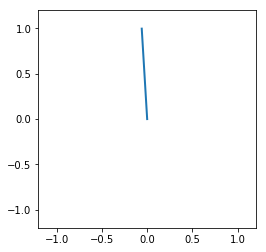

In [25]:
anim = animate(s)
HTML(anim.to_jshtml())

In [ ]:
for p in agent.net.parameters():
    print(p)